In [65]:
import pandas as pd
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import unicodedata

path = Path("../data/other sources/Smoothie_Ingredients_By_Goal.csv")
df = pd.read_csv(path)

df["Ingredient"] = df["Ingredient"].apply(
    lambda x: unicodedata.normalize("NFKD", str(x))  # remove accents
    .encode("ascii", "ignore")                       # drop non-ascii
    .decode("utf-8")                                 # decode to string
    .strip()                                         # trim whitespace
    .lower()                                         # lowercase
)

df["Ingredient_clean"] = df["Ingredient"].str.title()  # just for display

# Remove duplicates across layers, keeping the first occurrence
df = df.drop_duplicates(subset=["Ingredient"], keep="first")
print(df["Ingredient_clean"].unique())



['Coconut Water' 'Orange Juice' 'Almond Milk' 'Oat Milk' 'Green Tea'
 'Cashew Milk' 'Macadamia Milk' 'Watermelon Juice' 'Maple Water'
 'Carrot Juice' 'Apple Juice' 'Banana' 'Mango' 'Pineapple' 'Dates'
 'Peaches' 'Berries' 'Apple' 'Papaya' 'Cantaloupe' 'Pear' 'Acai Puree'
 'Rolled Oats' 'Chia Seeds' 'Psyllium Husk' 'Flaxseeds' 'Apple Skin'
 'Beetroot' 'Barley Flakes' 'Quinoa Flakes' 'Pumpkin Puree' 'Figs'
 'Prunes' 'Greek Yogurt' 'Hemp Protein' 'Silken Tofu' 'Peanut Butter'
 'Sunflower Seed Butter' 'Skyr' 'Pumpkin Seed Protein' 'Spirulina'
 'Ricotta' 'Almond Butter' 'Cinnamon' 'Nutmeg' 'Cardamom'
 'Vanilla Extract' 'Maca Powder' 'Cacao Nibs' 'Shredded Coconut' 'Mint'
 'Orange Zest' 'Rosewater' 'Sea Salt' 'Water' 'Unsweetened Almond Milk'
 'Cucumber Water' 'Cold Brew Tea' 'Celery Juice' 'Lemon Water'
 'Spinach Water' 'Bone Broth' 'Hibiscus Tea' 'Ice Cubes' 'Zucchini'
 'Cucumber' 'Spinach' 'Kale' 'Cauliflower' 'Avocado' 'Green Apple'
 'Celery' 'Broccoli' 'Beet' 'Konjac Powder' 'Apple Pect

In [66]:
from rapidfuzz import fuzz, process
import pandas as pd
import re

# Step 1: Normalize and clean
df['Ingredient_clean'] = df['Ingredient_clean'].str.lower().str.strip()

# Step 2: Remove common modifiers to focus on core ingredient
def simplify_ingredient(text):
    modifiers = ['unsweetened', 'organic', 'raw', 'fresh', 'natural', 'pure', 'cold brew']
    words = text.split()
    return ' '.join([w for w in words if w not in modifiers])

df['Ingredient_simplified'] = df['Ingredient_clean'].apply(simplify_ingredient)

# Step 3: Build master list and map similar ingredients
unique_ingredients = sorted(df['Ingredient_simplified'].unique())
ingredient_map = {}
processed = set()

for i, ingredient in enumerate(unique_ingredients):
    if ingredient in processed:
        continue
    matches = process.extract(ingredient, unique_ingredients[i+1:], scorer=fuzz.token_sort_ratio)
    for match, score, _ in matches:
        if score > 80:  # Lower threshold
            ingredient_map[match] = ingredient
            processed.add(match)

# Step 4: Map back to the original DataFrame
df['Ingredient_deduped'] = df['Ingredient_simplified'].apply(lambda x: ingredient_map.get(x, x))

# Step 5: Print summary
print(f"Unique ingredients after deduping: {df['Ingredient_deduped'].unique()}")

Unique ingredients after deduping: ['coconut water' 'orange juice' 'almond milk' 'oat milk' 'green tea'
 'cashew milk' 'macadamia milk' 'watermelon juice' 'maple water'
 'carrot juice' 'apple juice' 'banana' 'mango' 'pineapple' 'dates'
 'peaches' 'berries' 'apple' 'papaya' 'cantaloupe' 'pear' 'acai puree'
 'rolled oats' 'chia seeds' 'psyllium husk' 'flaxseed' 'apple skin'
 'beetroot' 'barley flakes' 'quinoa flakes' 'pumpkin puree' 'figs'
 'prunes' 'greek yogurt' 'hemp protein' 'silken tofu' 'nut butter'
 'sunflower seed butter' 'skyr' 'pumpkin seed protein' 'spirulina'
 'ricotta' 'almond butter' 'cinnamon' 'nutmeg' 'cardamom'
 'vanilla extract' 'cacao powder' 'cacao nibs' 'shredded coconut' 'mint'
 'orange zest' 'rosewater' 'sea salt' 'water' 'cucumber water'
 'cold brew tea' 'celery juice' 'lemon water' 'spinach water' 'bone broth'
 'hibiscus tea' 'ice cubes' 'zucchini' 'cucumber' 'spinach' 'kale'
 'cauliflower' 'avocado' 'green apple' 'celery' 'broccoli' 'beet'
 'konjac powder' 'appl

Ingredient_deduped
acacia fiber        1
mango               1
manuka honey        1
maple water         1
matcha              1
milk                1
mint                1
nutmeg              1
oat beta-glucans    1
oat bran            1
Name: sum_rows, dtype: int64


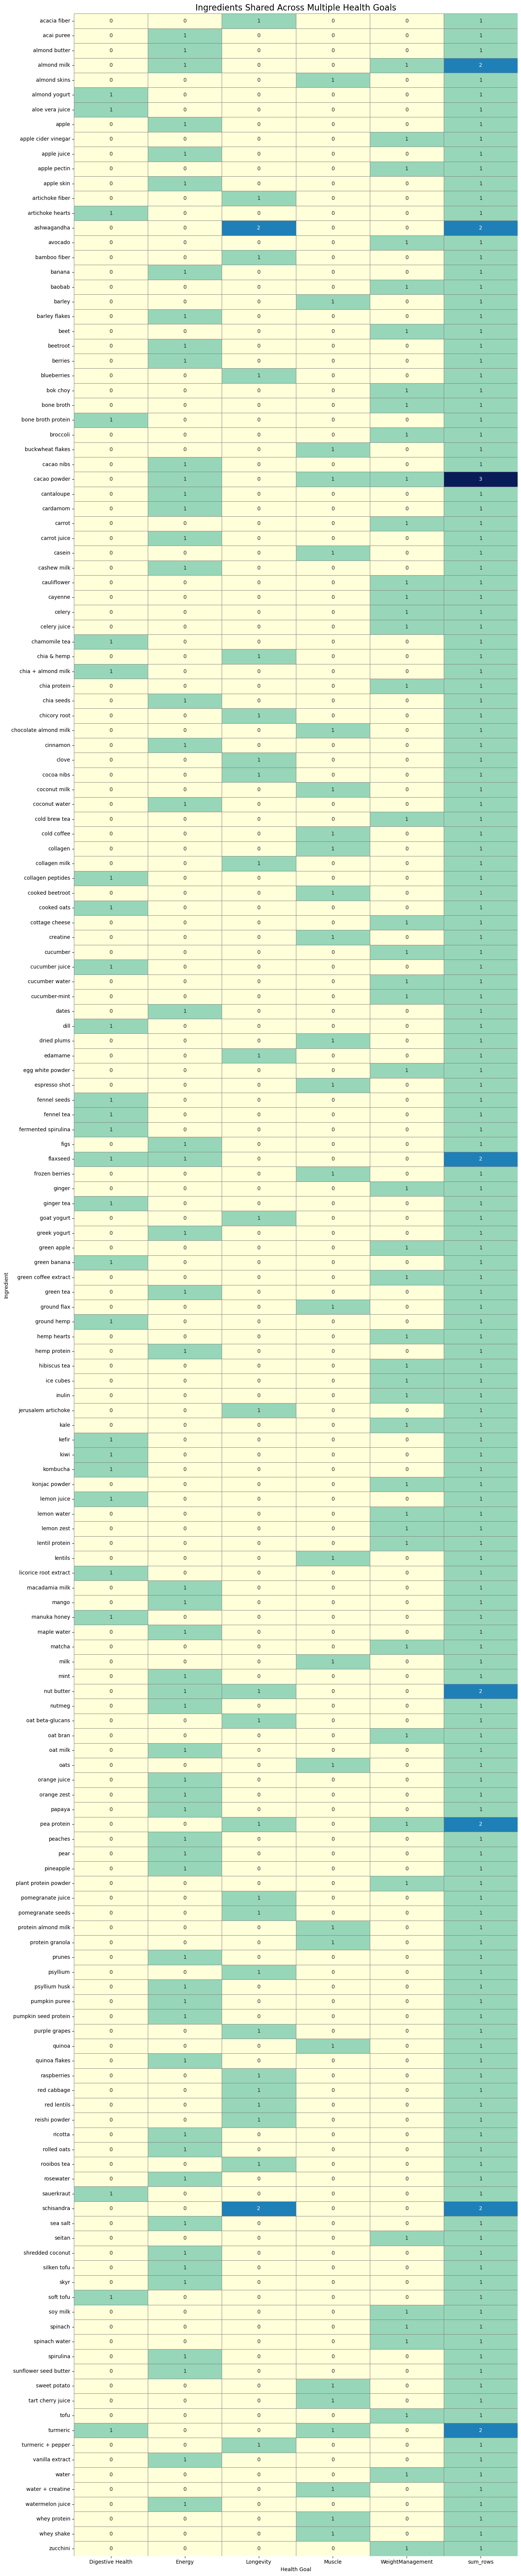

In [52]:
# ---- Step 2: Create a pivot table ----
pivot_df = df.pivot_table(index="Ingredient_deduped", columns="Goal", aggfunc="size", fill_value=0)

pivot_df["sum_rows"] = pivot_df.sum(axis=1)
print(pivot_df["sum_rows"].sort_values(ascending=True).head(10))
# ---- Step 4: Plot the heatmap ----
plt.figure(figsize=(14, max(6, len(pivot_df) * 0.4)))
sns.heatmap(pivot_df, cmap="YlGnBu", cbar=False, linewidths=0.5, linecolor='gray', annot=True, fmt="d")

plt.title("Ingredients Shared Across Multiple Health Goals", fontsize=16)
plt.ylabel("Ingredient")
plt.xlabel("Health Goal")
plt.tight_layout()
plt.show()

In [60]:
import requests
import pandas as pd

API_KEY = "3NXC4qCEungB3X9wpybSvCyhrSAFlpOyVzhzP6zC"
SEARCH_URL = "https://api.nal.usda.gov/fdc/v1/foods/search"
DETAIL_URL = "https://api.nal.usda.gov/fdc/v1/food/"

# Map USDA nutrient names to your columns
nutrient_map = {
    "Protein": "Protein",
    "Fiber, total dietary": "Fiber",
    "Iron, Fe": "Iron",
    "Magnesium, Mg": "Magnesium",
    "Thiamin": "B-Vitamins",       # Vitamin B1
    "Riboflavin": "B-Vitamins",    # Vitamin B2
    "Niacin": "B-Vitamins",        # Vitamin B3
    "Vitamin B-6": "B-Vitamins",
    "Vitamin B-12": "B-Vitamins"
}

def fetch_nutrition(ingredient):
    # Step 1: Search for the food
    search_params = {
        "query": ingredient,
        "api_key": API_KEY,
        "pageSize": 1
    }
    search_response = requests.get(SEARCH_URL, params=search_params).json()
    
    if "foods" not in search_response or not search_response["foods"]:
        return {}

    fdc_id = search_response["foods"][0]["fdcId"]

    # Step 2: Get detailed nutrient info
    detail_params = {"api_key": API_KEY}
    detail_response = requests.get(f"{DETAIL_URL}{fdc_id}", params=detail_params).json()

    # Step 3: Extract relevant nutrients
    data = {v: 0 for v in set(nutrient_map.values())}  # Initialize all target nutrients to 0

    for nutrient in detail_response.get("foodNutrients", []):
        # Safely navigate nested dict
        nutrient_info = nutrient.get("nutrient", {})
        name = nutrient_info.get("name", "")
        value = nutrient.get("amount", 0) or nutrient.get("value", 0)

        if name in nutrient_map:
            mapped_name = nutrient_map[name]
            data[mapped_name] += value or 0

# Try on a few ingredients
ingredients = ['chia seeds', 'banana', 'almond milk']
nutrition_data = []

for ing in ingredients:
    print(f"Fetching: {ing}")
    nutrition_data.append(fetch_nutrition(ing))

df = pd.DataFrame(nutrition_data, index=ingredients)
print(df)

Fetching: chia seeds
Fetching: banana
Fetching: almond milk
                0
chia seeds   None
banana       None
almond milk  None


In [ ]:
import pandas as pd
from rapidfuzz import process, fuzz

# Load USDA data
df_food = pd.read_csv("food.csv", usecols=["fdc_id", "description"])
df_nutrient = pd.read_csv("food_nutrient.csv", usecols=["fdc_id", "nutrient_id", "amount"])
df_nutrient_name = pd.read_csv("nutrient.csv", usecols=["id", "name", "unit_name"])

# Your ingredient list
ingredients = df['Ingredient_deduped'].unique()
# Match function
def match_ingredient(ingredient):
    match, score, idx = process.extractOne(ingredient, df_food["description"], scorer=fuzz.token_sort_ratio)
    print(f"Matching '{ingredient}' found: {match} (score: {score})")
    return pd.Series({
        "input": ingredient,
        "matched": match,
        "score": score,
        "fdc_id": df_food.loc[idx, "fdc_id"]
    })

# Match all ingredients
matches = pd.DataFrame([match_ingredient(ing) for ing in ingredients])
print("MATCHES:\n", matches)

# Merge to nutrient data
df_all = matches.merge(df_nutrient, on="fdc_id").merge(df_nutrient_name, left_on="nutrient_id", right_on="id")


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [76]:
df_all = df_all[df_all["score"]>=70]
# Pivot to wide table: rows = ingredient, columns = nutrients
df_pivot = df_all.pivot_table(index="input", columns="name", values="amount", aggfunc="first")

# Show result
print("NUTRIENT TABLE:\n", df_pivot.head())

NUTRIENT TABLE:
 name                   Alcohol, ethyl  Ash  Caffeine  Calcium, Ca  \
input                                                               
almond butter                     0.0  NaN       0.0        263.0   
barley                            0.0  NaN       0.0         11.0   
celery juice                      0.0  NaN       0.0         46.0   
chia seeds                        0.0  NaN       0.0        631.0   
chocolate almond milk             0.0  NaN       1.0        161.0   

name                   Carbohydrate, by difference  Carotene, alpha  \
input                                                                 
almond butter                                21.11              0.0   
barley                                       27.23              0.0   
celery juice                                  3.32              0.0   
chia seeds                                   42.12              0.0   
chocolate almond milk                         7.44              0.0   

n

In [92]:
# Install the latest openai package
#!pip install --upgrade openai

import json
import pandas as pd
import time
from openai import OpenAI

# Load API key from JSON file
with open("smoothies_ai.json", "r") as f:
    key_data = json.load(f)

# Create OpenAI client using the key
client = OpenAI(api_key=key_data["OPENAI_API_KEY"])

# Define the GPT query function
def ask_gpt(ingredient):
    prompt = f"""You are a nutritional database expert.

    For the ingredient "{ingredient}", return a JSON with the following keys and fill in the most accurate nutritional content **per 100g or 100ml** of the ingredient:

    - "Complex Carbohydrates" (grams)
    - "Iron" (mg)
    - "B-Vitamins" (list of B1, B2, B3, B6, B9, B12 in mg or µg)
    - "Magnesium" (mg)
    - "Adaptogen" (Yes/No)
    - "Fiber" (grams)
    - "Low Glycemic Load" (Yes/No)
    - "Protein" (grams)
    - "Prebiotics" (Yes/No)
    - "Probiotics" (Yes/No)
    - "BCAAs" (grams or Yes/No if unknown)
    - "Creatine" (grams or Yes/No)
    - "Antioxidants" (ORAC value if available, or list)
    - "Polyphenols" (mg)
    - "Omega-3" (grams or mg)
    - "Anti-inflammatory agents" (Yes/No or list)

    Respond ONLY with JSON. Round numerical values if needed and include "Unknown" if data isn't available.
    """

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}]
        )
        content = response.choices[0].message.content.strip()
        return json.loads(content)
    except Exception as e:
        print(f"Error parsing response for '{ingredient}': {e}")
        return None

# ---- Replace this with your actual DataFrame ---
# Load or define your DataFrame containing the ingredients
# Example:
# df = pd.read_csv("your_file.csv")
# For demo:
# df = pd.DataFrame({"Ingredient_deduped": ["banana", "almond milk", "chia seeds"]})
# -------------------------------------------------

# Collect results
ingredients = df['Ingredient_deduped'].unique()
results = {}

for ing in ingredients:
    print(f"Processing: {ing}")
    data = ask_gpt(ing)
    if data:
        results[ing] = data
    time.sleep(1.5)  # Respect rate limits

# Convert to DataFrame
df_nutrients = pd.DataFrame.from_dict(results, orient='index')
df_nutrients.index.name = "Ingredient"
df_nutrients.reset_index(inplace=True)

# Save to CSV
df_nutrients.to_csv("nutrient_matrix_amounts.csv", index=False)

Processing: coconut water
Processing: orange juice
Processing: almond milk
Processing: oat milk
Processing: green tea
Processing: cashew milk
Processing: macadamia milk
Processing: watermelon juice
Processing: maple water
Processing: carrot juice
Processing: apple juice
Processing: banana
Processing: mango
Processing: pineapple
Processing: dates
Processing: peaches
Processing: berries
Processing: apple
Processing: papaya
Processing: cantaloupe
Processing: pear
Processing: acai puree
Processing: rolled oats
Processing: chia seeds
Processing: psyllium husk
Processing: flaxseed
Processing: apple skin
Processing: beetroot
Processing: barley flakes
Processing: quinoa flakes
Processing: pumpkin puree
Processing: figs
Processing: prunes
Error parsing response for 'prunes': Expecting ',' delimiter: line 2 column 32 (char 33)
Processing: greek yogurt
Processing: hemp protein
Processing: silken tofu
Processing: nut butter
Processing: sunflower seed butter
Processing: skyr
Processing: pumpkin see

In [82]:
response = client.models.list()
print([model.id for model in response.data])

['gpt-3.5-turbo', 'gpt-5-nano', 'gpt-5', 'gpt-5-mini-2025-08-07', 'gpt-5-mini', 'gpt-5-nano-2025-08-07', 'davinci-002', 'babbage-002', 'gpt-3.5-turbo-instruct', 'gpt-3.5-turbo-instruct-0914', 'dall-e-3', 'dall-e-2', 'gpt-3.5-turbo-1106', 'tts-1-hd', 'tts-1-1106', 'tts-1-hd-1106', 'text-embedding-3-small', 'text-embedding-3-large', 'gpt-3.5-turbo-0125', 'gpt-4o', 'gpt-4o-2024-05-13', 'gpt-4o-mini-2024-07-18', 'gpt-4o-mini', 'gpt-4o-2024-08-06', 'o1-mini-2024-09-12', 'o1-mini', 'gpt-4o-audio-preview-2024-10-01', 'gpt-4o-audio-preview', 'omni-moderation-latest', 'omni-moderation-2024-09-26', 'gpt-4o-audio-preview-2024-12-17', 'gpt-4o-mini-audio-preview-2024-12-17', 'o1-2024-12-17', 'o1', 'gpt-4o-mini-audio-preview', 'o3-mini', 'o3-mini-2025-01-31', 'gpt-4o-2024-11-20', 'gpt-4o-search-preview-2025-03-11', 'gpt-4o-search-preview', 'gpt-4o-mini-search-preview-2025-03-11', 'gpt-4o-mini-search-preview', 'gpt-4o-transcribe', 'gpt-4o-mini-transcribe', 'gpt-4o-mini-tts', 'o3-2025-04-16', 'o4-mini